In [1]:
# !pip install spacy nltk wordcloud
# !python -m spacy download pt_core_news_sm

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from wordcloud import WordCloud

# Oculta warnings do notebook
# import warnings
# warnings.filterwarnings('ignore')

# Configurações de visualização
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
nltk.download('stopwords')
spc_pt = spacy.load("pt_core_news_sm")

In [7]:
dataset_path = '../data/raw/'
df = pd.read_csv(f"{dataset_path}ErikakHilton-tweets.csv", sep=';')
print(df.shape)
df.info()

(22505, 49)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22505 entries, 0 to 22504
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       22505 non-null  object 
 1   date                      22505 non-null  object 
 2   rawContent                22505 non-null  object 
 3   renderedContent           22505 non-null  object 
 4   id                        22505 non-null  int64  
 5   user                      22505 non-null  object 
 6   replyCount                22505 non-null  int64  
 7   retweetCount              22505 non-null  int64  
 8   likeCount                 22505 non-null  int64  
 9   quoteCount                22505 non-null  int64  
 10  conversationId            22505 non-null  int64  
 11  lang                      22505 non-null  object 
 12  source                    0 non-null      float64
 13  sourceUrl                 0 non-null      float64

/tmp/ipykernel_2734/2857846567.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{dataset_path}ErikakHilton-2022-10-01-2022-11-01-2023-02-16T19:31:01.224464.csv", sep=';')


In [3]:
# Removendo colunas pouco informativas
drop_columns = [
    'renderedContent',  # Possui praticamente o mesmo que a rawContent
    'source', 'sourceUrl', 'sourceLabel', 'links', 'retweetedTweet',  # Muitos nulos
    'quotedTweet', 'coordinates', 'place', 'cashtags', 'card',   # Muitos nulos
    'viewCount', 'vibe', 'user_descriptionLinks', 'user_label',  # Muitos nulos
]
df = df.drop(drop_columns, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22505 entries, 0 to 22504
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       22505 non-null  object 
 1   date                      22505 non-null  object 
 2   rawContent                22505 non-null  object 
 3   id                        22505 non-null  int64  
 4   user                      22505 non-null  object 
 5   replyCount                22505 non-null  int64  
 6   retweetCount              22505 non-null  int64  
 7   likeCount                 22505 non-null  int64  
 8   quoteCount                22505 non-null  int64  
 9   conversationId            22505 non-null  int64  
 10  lang                      22505 non-null  object 
 11  media                     3282 non-null   object 
 12  inReplyToTweetId          21118 non-null  float64
 13  inReplyToUser             21118 non-null  object 
 14  mentio

In [3]:
# Checando e removendo linhas duplicadas
# Não sei ao certo pq isso aconteceu (pode ser um bug no scrapper ao pegar muitos dados), mas é fácil de tratar
duplicated_indexes = df[df.duplicated()].index
df = df.drop(duplicated_indexes)

In [15]:
# Separando tweets da Erika em uma serie
tweets_op = df[df.user == 'https://twitter.com/ErikakHilton'].rawContent
print(tweets_op[0])

Ao longo do dia estou recebendo denúncias, inclusive de pessoas presas há mais de 16h na estrada, sem água e sem comida, pelos bloqueios ilegais dos caminhoneiros.

Por isso, enviei requerimento para que a PRF nos dê informações sobre as dimensões dos atos e providencias tomadas. https://t.co/g0zRPmBLLX


# Pre Processamento

In [68]:
def filter_letters(text):
    # Remove non-letter characters and convert to lower case
    letters =  re.findall(r'\b[A-zÀ-úü://.]+\b', text.lower())
    return letters

def remove_stopwords(text):
    # Adicionando stopwords que não estão na lista do nltk 
    stopwords = nltk.corpus.stopwords.words('portuguese')
    stopwords.remove('não')
    extra_stopwords = ["'", "pra", "tá", "/", "https", "t.co/", "https://t.co/",]
    stopwords += extra_stopwords
    
    meaningful_words = [w for w in text if w not in stopwords]
    meaningful_words_text = " ".join(meaningful_words)
    return meaningful_words_text

def lemmatize(text):
    spc_letters =  spc_pt(text)
    tokens = [token.lemma_ if token.pos_ == 'VERB' else str(token) for token in spc_letters]

    # Tratamento especial para o verbo "ir"
    ir = ['vou', 'vais', 'vai', 'vamos', 'ides', 'vão']
    tokens = ['ir' if token in ir else str(token) for token in tokens]
    return " ".join(tokens)

def tokenize(text):
    return [word for word in text.split()]

In [69]:
def tweet_pre_process(text):
    text = filter_letters(text)
    text = remove_stopwords(text)
    return lemmatize(text)

processed_tweets = tweets_op.apply(tweet_pre_process)
tweet_tokens = processed_tweets.apply(tokenize)

# Análise Exploratória

In [70]:
tokens_list = tweet_tokens.sum()

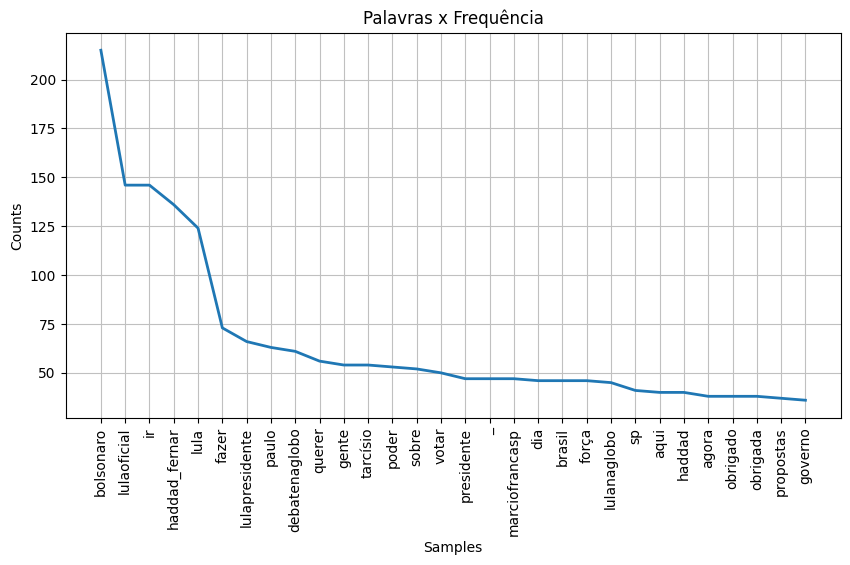

<AxesSubplot: title={'center': 'Palavras x Frequência'}, xlabel='Samples', ylabel='Counts'>

In [71]:
fd = nltk.FreqDist(tokens_list)

plt.figure(figsize=(10,5))
fd.plot(30, title = "Palavras x Frequência", cumulative=False)

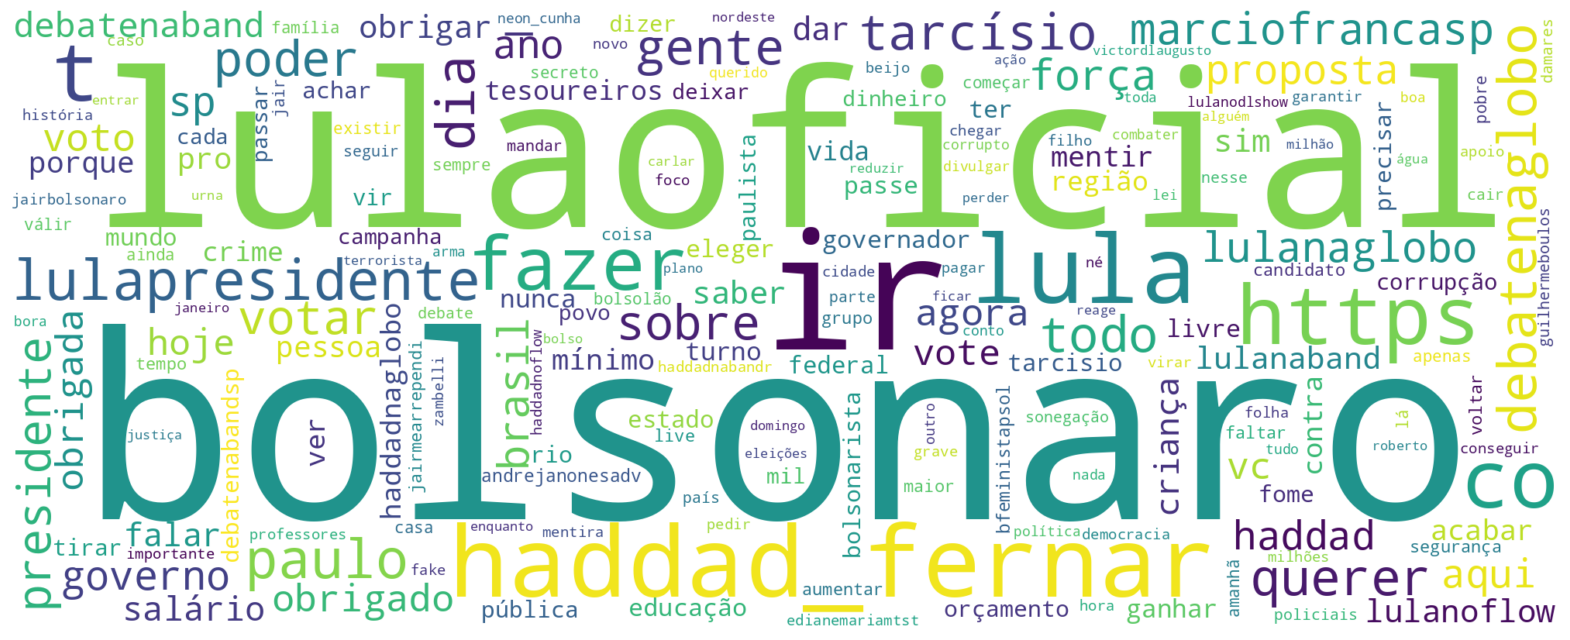

In [72]:
text = " ".join(tokens_list)
wordcloud = WordCloud(
    background_color="white",
    width=2000, height=800, 
    collocations=False
).generate(text)

fig = plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Feature Extraction

### Bag of Words

In [96]:
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(processed_tweets)
bow

<1436x3807 sparse matrix of type '<class 'numpy.int64'>'
	with 10780 stored elements in Compressed Sparse Row format>

In [97]:
bow = pd.DataFrame(bow.todense())

# Atribuindo nomes das colunas aos termos
vocabulary_map = {v: k for k, v in bow_vectorizer.vocabulary_.items()}
bow.columns = bow.columns.map(vocabulary_map)
bow.head()

,a_jessilane,a_scabim,aaa,aaaa,aaaaar,aaaao,aaaar,aaahahaha,abaixo,abalar,abaler,abandonar,abandone,abandono,abc,abertura,abestado,abjeto,abraço,abrir,absoluto,abstenção,absurdo,absurdos,absurr,abusar,acabamos,acabar,acatar,aceitar,acer,acessar,acesso,acessos,acessível,achar,achloett,acima,acobertar,acompanhar,acompanhario,acontecer,acordar,acorder,acordo,acreditar,acréscimo,acumular,acusar,adesivo,...,williancosta,wjcobzfdke,wkkcxnfkse,wshsjgiwcy,xgzdrvmohu,xiirqdlwmj,xpihniuvcw,xwovjmeudl,xxlehstuff,xxvinir,yamaguchi,yaodvvbirw,ylvkyvehnh,ylvkyvnelh,you,youtube,yptomhyxfx,ysroilpwli,yuriolivs,yzvjyactgn,zambelli,zambellinacadeio,zap,zfernandoc,zhxzvvpnzr,zombar,zulmira,zumbizelli,zvbbzidnty,água,áreas,árvore,ás,áudios,época,ícone,íntegra,ódio,óleo,órgãos,ótima,ótimas,ônibus,últimas,último,últimos,única,únicas,único,únicos
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### TF-IDF


In [113]:
# Instanciando TFIDF
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(processed_tweets)
tfidf

<1436x3807 sparse matrix of type '<class 'numpy.float64'>'
	with 10780 stored elements in Compressed Sparse Row format>

In [114]:
tfidf = pd.DataFrame(tfidf.todense())

# Atribuindo nomes das colunas aos termos
vocabulary_map = {v: k for k, v in tfidf_vectorizer.vocabulary_.items()}
tfidf.columns = tfidf.columns.map(vocabulary_map)
tfidf.head()

,a_jessilane,a_scabim,aaa,aaaa,aaaaar,aaaao,aaaar,aaahahaha,abaixo,abalar,abaler,abandonar,abandone,abandono,abc,abertura,abestado,abjeto,abraço,abrir,absoluto,abstenção,absurdo,absurdos,absurr,abusar,acabamos,acabar,acatar,aceitar,acer,acessar,acesso,acessos,acessível,achar,achloett,acima,acobertar,acompanhar,acompanhario,acontecer,acordar,acorder,acordo,acreditar,acréscimo,acumular,acusar,adesivo,...,williancosta,wjcobzfdke,wkkcxnfkse,wshsjgiwcy,xgzdrvmohu,xiirqdlwmj,xpihniuvcw,xwovjmeudl,xxlehstuff,xxvinir,yamaguchi,yaodvvbirw,ylvkyvehnh,ylvkyvnelh,you,youtube,yptomhyxfx,ysroilpwli,yuriolivs,yzvjyactgn,zambelli,zambellinacadeio,zap,zfernandoc,zhxzvvpnzr,zombar,zulmira,zumbizelli,zvbbzidnty,água,áreas,árvore,ás,áudios,época,ícone,íntegra,ódio,óleo,órgãos,ótima,ótimas,ônibus,últimas,último,últimos,única,únicas,único,únicos
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [115]:
tfidf.shape

(1436, 3807)

# Análise de Sentimentos

In [126]:
erika_df = df[df.user == 'https://twitter.com/ErikakHilton']
# erika_df = df.loc[:, 'user'] == 'https://twitter.com/ErikakHilton'
erika_df.shape

(1436, 50)

### Cluster Kmeans

In [127]:
# treinando algoritmo KMeans cluster para agrupar tweets similares
k = 2  # numero de clusters
kmeans = KMeans(n_clusters=k)
labels = kmeans.fit_predict(X)

# rotulando tweets baseado nos clusters
erika_df['sentiment_cluster'] = ['positive' if label == 0 else 'negative' for label in labels]

/home/paim/projects/complete_venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_2423/1186732100.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  erika_df['sentiment_cluster'] = ['positive' if label == 0 else 'negative' for label in labels]


### Latent Dirichlet Allocation

In [129]:
# treinando modelo LDA
n_topics = 2  # numero de topicos
lda = LatentDirichletAllocation(n_components=n_topics)
lda.fit(bow)

# atribuir os rotulos
topic_sentiments = ['positive', 'negative']
topic_labels = [topic_sentiments[i] for i in lda.transform(bow).argmax(axis=1)]

# rotular tweets
erika_df['sentiment_dirichlet'] = topic_labels

/tmp/ipykernel_2423/102355319.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  erika_df['sentiment_dirichlet'] = topic_labels


### Comparação

In [133]:
erika_df[['rawContent', 'sentiment_cluster', 'sentiment_dirichlet']]

,rawContent,sentiment_cluster,sentiment_dirichlet
0,"Ao longo do dia estou recebendo denúncias, inc...",negative,negative
2,@PalasAthenas18 Hahahhaha 💜💜💜,negative,negative
5,@Mendes2588 🫶🏾🫶🏾,negative,positive
8,@juknobel 🫶🏾,negative,negative
60,https://t.co/ggqXLxJG3S https://t.co/tNFJnDXKQL,negative,negative
...,...,...,...
22491,@marconythe1 @pedrorhuas 🫶🏾🫶🏾,negative,positive
22493,@neiomachado @RaulMarcelo Obrigada por essa fo...,negative,positive
22496,@VeraGoncalves50 @bibi_org @thainarafariapt @m...,positive,negative
22499,@helder_jhon @neon_cunha @marciofrancasp @Hadd...,positive,positive
